# **Import data**

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sqlite3
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import calendar
import ipywidgets as widgets
from IPython.display import display

path = "../input/soccer/"  #Insert path here
db = path + 'database.sqlite'
conn = sqlite3.connect(db)

with sqlite3.connect(db) as con:
    countries = pd.read_sql_query("SELECT * from Country", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    leagues = pd.read_sql_query("SELECT * from League", con)
    teams = pd.read_sql_query("SELECT * from Team", con)
    Player_detail = pd.read_sql_query("SELECT * from Player_Attributes", con)
    Player = pd.read_sql_query("SELECT * from Player", con)
    

tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
tables

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


# **Which match has the highest number of goals scored each season?**

In [2]:
mostgoals = pd.read_sql(
"""
SELECT subquery.name, subquery.home_team,subquery.away_team, subquery.home_goals ,subquery.away_goals ,
MAX(subquery.max_goals) AS total_goals, subquery.season
FROM(
SELECT l.name, t1.team_long_name AS home_team, t2.team_long_name AS away_team, m.home_team_goal AS home_goals, m.away_team_goal AS away_goals, strftime('%Y', m.date) AS season, MAX(m.home_team_goal + m.away_team_goal) AS max_goals
FROM league AS l
INNER JOIN match AS m ON l.id = m.league_id
INNER JOIN team AS t1 ON m.home_team_api_id = t1.team_api_id
INNER JOIN team AS t2 ON m.away_team_api_id = t2.team_api_id
GROUP BY l.name, home_team, season
ORDER BY max_goals DESC ) as subquery
GROUP BY subquery.season

""", conn
)

mostgoals

,name,home_team,away_team,home_goals,away_goals,total_goals,season
0,Germany 1. Bundesliga,SV Werder Bremen,TSG 1899 Hoffenheim,5,4,9,2008
1,England Premier League,Tottenham Hotspur,Wigan Athletic,9,1,10,2009
2,Scotland Premier League,Motherwell,Hibernian,6,6,12,2010
3,England Premier League,Manchester United,Arsenal,8,2,10,2011
4,England Premier League,Arsenal,Newcastle United,7,3,10,2012
5,Germany 1. Bundesliga,FC Bayern Munich,Hamburger SV,9,2,11,2013
6,Spain LIGA BBVA,RC Deportivo de La Coruña,Real Madrid CF,2,8,10,2014
7,Spain LIGA BBVA,Real Madrid CF,Rayo Vallecano,10,2,12,2015
8,England Premier League,Norwich City,Liverpool,4,5,9,2016


# **Which team has the highest number of wins in their home or away games each season?**

In [3]:
#home
homewins = pd.read_sql(
"""
SELECT subquery.name, subquery.team, MAX(subquery.home_wins) AS max_home_wins, subquery.season
FROM (
    SELECT l.name, t1.team_long_name AS team, COUNT(*) AS home_wins, strftime('%Y', m.date) AS season
    FROM league AS l
    INNER JOIN match AS m ON l.id = m.league_id
    INNER JOIN team AS t1 ON m.home_team_api_id = t1.team_api_id
    WHERE m.home_team_goal > m.away_team_goal
    GROUP BY l.name, team, season
) AS subquery
GROUP BY subquery.season;
""", conn)
homewins

,name,team,max_home_wins,season
0,England Premier League,Manchester United,16,2008
1,Spain LIGA BBVA,FC Barcelona,18,2009
2,England Premier League,Manchester United,18,2010
3,England Premier League,Manchester City,18,2011
4,Spain LIGA BBVA,FC Barcelona,18,2012
5,Italy Serie A,Juventus,19,2013
6,Italy Serie A,Juventus,16,2014
7,Italy Serie A,Juventus,16,2015
8,Portugal Liga ZON Sagres,Estoril Praia,9,2016


In [4]:
#away
awaywins = pd.read_sql(
"""
SELECT subquery.name, subquery.team, MAX(subquery.away_wins) AS max_away_wins, subquery.season
FROM (
    SELECT l.name, t1.team_long_name AS team, COUNT(*) AS away_wins, strftime('%Y', m.date) AS season
    FROM league AS l
    INNER JOIN match AS m ON l.id = m.league_id
    INNER JOIN team AS t1 ON m.away_team_api_id = t1.team_api_id
    WHERE m.home_team_goal < m.away_team_goal
    GROUP BY l.name, team, season
) AS subquery
GROUP BY subquery.season;
""", conn)
awaywins

,name,team,max_away_wins,season
0,England Premier League,Chelsea,14,2008
1,Spain LIGA BBVA,FC Barcelona,13,2009
2,Scotland Premier League,Rangers,16,2010
3,Spain LIGA BBVA,Real Madrid CF,16,2011
4,Germany 1. Bundesliga,FC Bayern Munich,15,2012
5,Scotland Premier League,Celtic,15,2013
6,Scotland Premier League,Celtic,14,2014
7,France Ligue 1,Paris Saint-Germain,15,2015
8,Italy Serie A,Roma,10,2016


# **Top 3 players each season**

In [5]:
Top3 = pd.read_sql(
    """
SELECT DISTINCT subquery.player_name, subquery.overall_rating, subquery.season ,subquery.Rank
FROM (
    SELECT DISTINCT p.player_name, f.overall_rating, strftime('%Y', f.date) AS season,
        ROW_NUMBER() OVER(PARTITION BY strftime('%Y', f.date) ORDER BY f.overall_rating DESC) AS Rank
    FROM player AS p
    INNER JOIN player_attributes AS f
    USING(player_api_id)
    GROUP BY player_name ,season
) AS subquery
WHERE subquery.Rank <= 3 
GROUP BY subquery.season, subquery.Rank;
    """, conn)
Top3


,player_name,overall_rating,season,Rank
0,Alessandro Nesta,91,2007,1
1,Cristiano Ronaldo,91,2007,2
2,Gianluigi Buffon,91,2007,3
3,Cristiano Ronaldo,91,2008,1
4,Iker Casillas,91,2008,2
5,Gianluigi Buffon,90,2008,3
6,Iker Casillas,90,2009,1
7,Lionel Messi,90,2009,2
8,Cristiano Ronaldo,89,2009,3
9,Lionel Messi,90,2010,1


# **leagues**

**Total goals for leagues in the season**

In [6]:
matches['goals'] = matches['home_team_goal'] + matches['away_team_goal']

matches = matches.merge(leagues, left_on='league_id', right_on='id', suffixes=('_matches', '_leagues'))

matches['date'] = pd.to_datetime(matches['date'])

matches['Year'] = matches['date'].dt.year

year_dropdown = widgets.Dropdown(options=matches['Year'].unique(), description='Select Year')

def updateplot(year):
    filteredmatches = matches[matches['Year'] == year]
    goalspername = filteredmatches.groupby('name')['goals'].sum()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=goalspername.values, y=goalspername.index, order=goalspername.sort_values(ascending=False).index)
    plt.xticks(rotation=90)
    plt.ylabel('league')
    plt.xlabel('goals')
    plt.title(f'Total goals for leagues in {year}')
    plt.show()

display(year_dropdown)

widgets.interact(updateplot, year=year_dropdown)

Dropdown(description='Select Year', options=(2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016), value=2008…

interactive(children=(Dropdown(description='Select Year', options=(2008, 2009, 2010, 2011, 2012, 2013, 2014, 2…

<function __main__.updateplot(year)>

**Top 10 Teams with the Highest Wins in Season**

In [7]:
matches['date'] = pd.to_datetime(matches['date'])

matches['Year'] = matches['date'].dt.year

merged_data = matches.merge(teams, left_on='home_team_api_id', right_on='team_api_id')
merged_data = merged_data.merge(teams, left_on='away_team_api_id', right_on='team_api_id', suffixes=('_home', '_away'))

year_dropdown = widgets.Dropdown(options=matches['Year'].unique(), description='Select Year')

def update_plot(year):
    filtered_data = merged_data[merged_data['Year'] == year]
    
    home_wins = filtered_data[filtered_data['home_team_goal'] > filtered_data['away_team_goal']]['team_long_name_home'].value_counts()
    away_wins = filtered_data[filtered_data['away_team_goal'] > filtered_data['home_team_goal']]['team_long_name_away'].value_counts()
    
    total_wins = home_wins.add(away_wins, fill_value=0)
    
    top_10_teams = total_wins.nlargest(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_10_teams.values, y=top_10_teams.index)
    plt.xticks(rotation=90)
    plt.title(f"Top 10 Teams with the Highest Wins in {year}")
    plt.xlabel("Number of Wins")
    plt.ylabel("Team")
    plt.show()

display(year_dropdown)
widgets.interact(update_plot, year=year_dropdown)

Dropdown(description='Select Year', options=(2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016), value=2008…

interactive(children=(Dropdown(description='Select Year', options=(2008, 2009, 2010, 2011, 2012, 2013, 2014, 2…

<function __main__.update_plot(year)>

# **Arsenal**

In [8]:
Arsenalid = pd.read_sql(
"""
select *
from team
where team_long_name = "Arsenal"
""", conn
)
Arsenalid

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,3459,9825,1,Arsenal,ARS


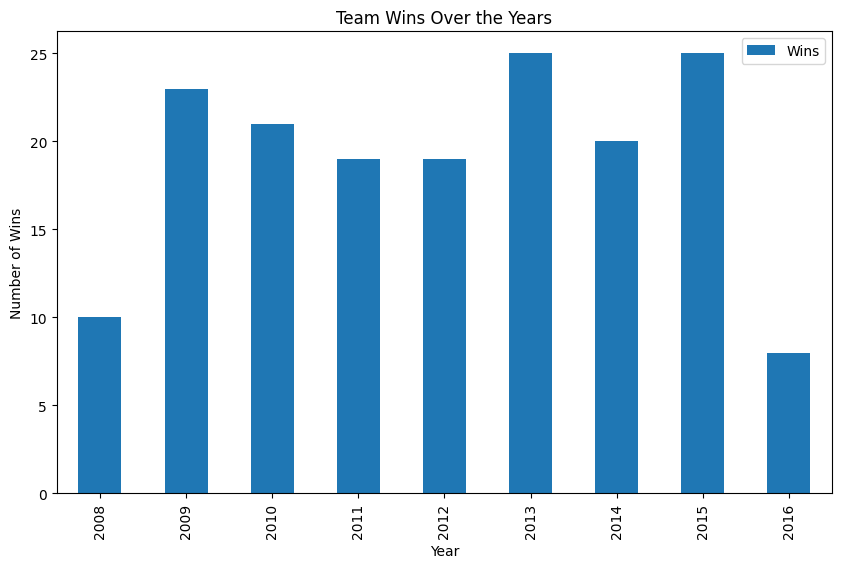

In [9]:
team_matches = matches[(matches['home_team_api_id'] == 9825) | (matches['away_team_api_id'] == 9825)]

team_wins = team_matches.apply(lambda row: 1 if (row['home_team_api_id'] == 9825 and row['home_team_goal'] > row['away_team_goal']) or (row['away_team_api_id'] == 9825 and row['away_team_goal'] > row['home_team_goal']) else 0, axis=1)

team_wins_data = pd.DataFrame({'Year': team_matches['Year'], 'Wins': team_wins})
team_wins_data = team_wins_data.groupby('Year').sum()

plt.figure(figsize=(10, 6))
team_wins_data['Wins'].plot(kind='bar', label='Wins')
plt.title('Team Wins Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Wins')
plt.legend()
plt.show()

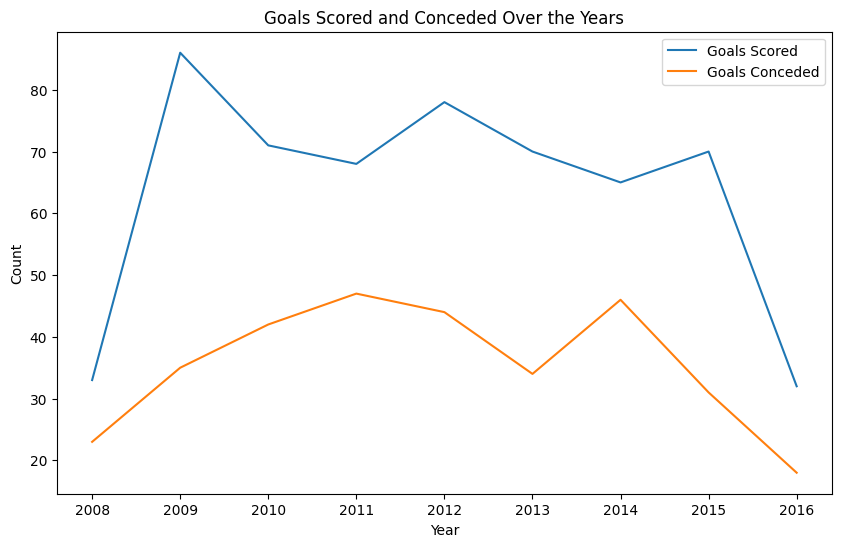

In [10]:
team_matches = matches[(matches['home_team_api_id'] == 9825) | (matches['away_team_api_id'] == 9825)]
team_goals_scored = team_matches.apply(lambda row: row['home_team_goal'] if row['home_team_api_id'] == 9825 else row['away_team_goal'], axis=1)
team_goals_conceded = team_matches.apply(lambda row: row['away_team_goal'] if row['home_team_api_id'] == 9825 else row['home_team_goal'], axis=1)

team_data = pd.DataFrame({'Year': team_matches['Year'], 'Wins': team_wins, 'Goals Scored': team_goals_scored, 'Goals Conceded': team_goals_conceded})
team_data = team_data.groupby('Year').sum()

plt.figure(figsize=(10, 6))
team_data['Goals Scored'].plot(label='Goals Scored')
team_data['Goals Conceded'].plot(label='Goals Conceded')
plt.title('Goals Scored and Conceded Over the Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.show()

# **According to FIFA, did the players who played in 2013 reach their potential in 2015?**

In [11]:
Player_detail['date'] = pd.to_datetime(Player_detail['date'])
Player_detail['Year'] = Player_detail['date'].dt.year

potential_2013 = Player_detail[Player_detail['Year'] == 2013][['player_api_id', 'potential']]
overall_rating_2015 = Player_detail[Player_detail['Year'] == 2015][['player_api_id', 'overall_rating']]

merged_data = pd.merge(potential_2013, overall_rating_2015, on='player_api_id', how='inner')

correlation_coefficient = merged_data['potential'].corr(merged_data['overall_rating'])
correlation_coefficient

0.7354182902349023